In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from  matplotlib.image import imread
import os 

### Example: Images are very sparse in fourier basis 

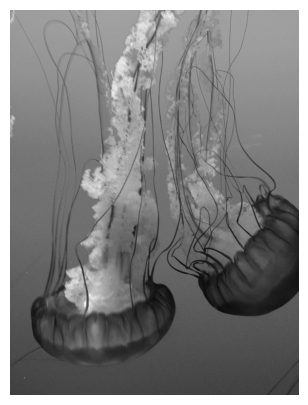

In [2]:
A = imread(os.path.join('DATA','jelly.jpg'))
A_gray = np.mean(A,axis=-1)

plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams.update({'font.size': 18})
plt.imshow(A_gray,cmap='gray')
plt.axis('off')
plt.show()

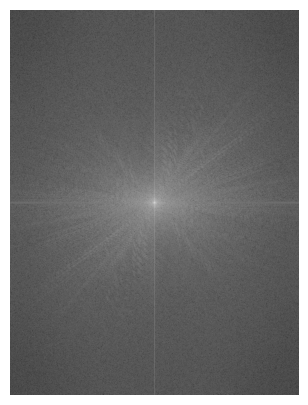

In [3]:
# compute the FFT of the image 

A_fft = np.fft.fft2(A_gray)                      # get the fourier coeffcients
F = np.log(np.abs(np.fft.fftshift(A_fft)+1))     # arrange the freq(st zero freq. at the middle) and get magnitude
plt.imshow(F,cmap='gray')                        # plot magnitude of FT coef. 
plt.axis('off')
plt.show()

(-0.5, 767.5, 1023.5, -0.5)

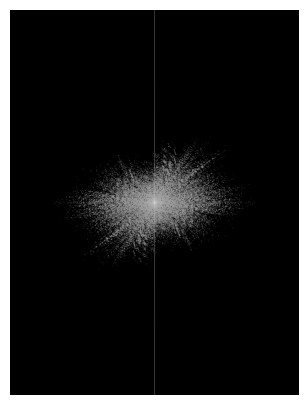

In [4]:
# plot only the larget fourier coefficients (by magnitude)

keep = 0.05
A_fft_sort = np.sort(np.abs(np.reshape(A_fft,-1)))                  # sort the Fourier coeff.
A_freq_cut = A_fft_sort[int(np.floor(len(A_fft_sort)*(1-keep)))]    # the freq cutoff (magnitude) that select 5% largest coeffs.
indx = np.abs(A_fft) > A_freq_cut                                           # create a boolean mask to filter larger freq.components 
A_fft_filt = A_fft * indx                                           # Filtered freq. matrix 

A_fft_filt_sort = np.log(np.abs(np.fft.fftshift(A_fft_filt)) + 1)   # put fft mag. in log scale after ordering (zero freq. at middle)

#plot
plt.imshow(A_fft_filt_sort,cmap='gray')
plt.axis('off')

/tmp/ipykernel_19014/2229518707.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  A_recon = np.fft.ifft2(A_fft_filt).astype('uint8')


(-0.5, 767.5, 1023.5, -0.5)

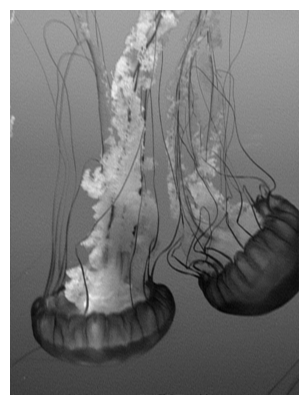

In [5]:
# reconstruct the image using the filtered fourior coeffcinets 

A_recon = np.fft.ifft2(A_fft_filt).astype('uint8')
plt.imshow(A_recon,cmap='gray')
plt.axis('off')

### Compressed sensing 

1. High resolution image can be reshaped into tall skinny vector $x$, and it is believed that the image is sparse (represented by sparse matrix $s$) in some transformation matrix $\Psi$

$\hspace{1 cm}x = \Psi s$

2. When a signal is sparse in some universal transformation basis ($\Psi$), it can be get away by measuring not the full image ($x$), but massively downsampled image $y$ as long as measurement matrix ($c$) is measured in a random way

$\hspace{1 cm} y = c\Psi s$, here $c$ matrix is randomly pulling pixels from $x$

3. Optimization: $\hat{s} = arg_s min ||c\Psi s -y||_2 + \lambda ||s||_1$, where $||s||_1 = \sum_{k=1}^n |s_k|$


4. LASSO regression for sparsity promoting feature selection 

$\hspace{1 cm} \hat{x} = arg_x min ||Ax - b||_2 + \lambda ||x||_1$ give the sparse feature vector $\hat{x}$ for linear system of eqs. $Ax = b$


5. Robust PCA 

$\hspace{0.75 cm}$ least square regression and PCA are highly susceptible for outliers and corrupted data 

$\hspace{0.75 cm}$ decompose a data matrix $X$ into a structured low rank matrix $L$ and a sparse matrix $S$ containing outliers and corrupt data $X = L + S$

$\hspace{0.75 cm}$ optimization $ min_{L,S} ||L||_{*} + \lambda ||S||_1$ subject to $L + S  = X$,l where $||L||_{*}$ is sum of sigular values 


6. Sparse sensor placement 

$\hspace{0.75 cm}$  Optimized sensor placement in a tailroaded library ($\Psi_r$), for example $\Psi_r = \tilde{U}_r$ from SVD, where $\tilde{U}_r$ can be eign faces

$\hspace{0.75 cm}$ $C$ is selected from pivot points from QR factorization 

$\hspace{0.75 cm}$ QR factorization with column pivoting yields r point sensors (pivots), that best sample r basis modes $\Psi_r$ s.t. $\Psi_r^T C^T = QR$

7. Sparse classification 

$\hspace{0.75 cm}$ For classification even fewer sensors may be required than for reconstruction
 
$ \\ \hspace{0.75 cm}$ For ex. sparse sensors may be selected that contain the most discriminating infromation to charaterize two catogories of data

$ \\ \hspace{0.75 cm}$ Given library of r SVD modes $\Psi_r$, it is often possible to identify a vector $w \epsilon R^r$ that maximally distinguishes between 2 catogories of data

$ \\ \hspace{0.75 cm}   s = arg_s min ||s'||_1 $ subject to $\Psi_t^T s' = w$

### Example: Under-determined system of equations

 
1. $y_{200 \times 1}=\Theta_{200 \times 1000} s_{1000 \times 1}$ solve for $s$

2. matrix $s$ has 1000 unkowns for 200 equations 

3. The least square solution of $s$ (given by psudo-inverse), minimize $L_2$ norm 

4. We can get the sparse matrix for $s$ by using $L_1$ norm (this promotes the sparsity)

In [36]:
# create underdtermined system of equations 
n = 1000
p = 200 
Theta = np.random.randn(p,n) 
y = np.random.randn(p)

# L2 solution 
s_L2 = np.linalg.pinv(Theta) @ y 

In [37]:
# L1 solution(this promotes the sparsity)
from scipy.optimize import minimize

def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type':'eq','fun':lambda x: Theta@x -y})
x0 = np.linalg.pinv(Theta) @ y                       # initialize with L2 norm solution 

res = minimize(L1_norm,x0,method='SLSQP',constraints=constr)
s_L1 = res.x

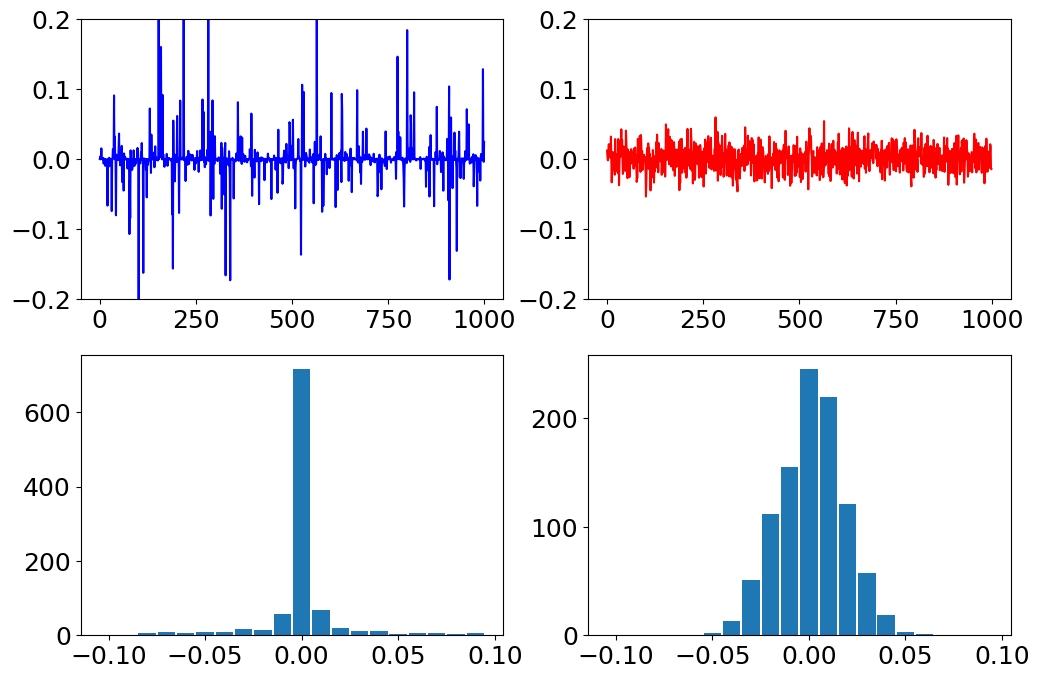

In [38]:
# plot 
fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)
axs[0].plot(s_L1,color='b',linewidth=1.5)
axs[0].set_ylim(-0.2,0.2)
axs[1].plot(s_L2,color='r',linewidth=1.5)
axs[1].set_ylim(-0.2,0.2)
axs[2].hist(s_L1,bins=np.arange(-0.105,0.105,0.01),rwidth=0.9)
axs[3].hist(s_L2,bins=np.arange(-0.105,0.105,0.01),rwidth=0.9)

plt.show()

### Example: Robust regression


1. The normal regression line (ex. from p-inverse, which promotes L2 norm) is largely affected by outliers and corrupted data

2. We can use L1 promoted regression (or robust regression) to prevent biasing from outliers in the data i.e. $||Ax-b||_1$

In [115]:
# generate data with a known slope 
x =  np.random.randn(25,1) * 4 -2             # random data  from [-2,2]
b = 0.9 * x + 0.1 * np.random.randn(len(x),1) # generate data with 0.9 slope. i.e. Ax = b , with A =0.9 

# get the LSq solution 
A_lestsq = np.linalg.pinv(x) @ b              # least sq. slope without outlier 
print(f'leat sq. sol ={A_lestsq[0]}')

leat sq. sol =[0.8898742]


In [116]:
# Add a outlier to the data (change the last number)
b[-1] = -5.5

# least sq after the outlier 
A_lestsq_corrupt = np.linalg.pinv(x) @ b              # least sq. slope without outlier 
print(f'leat sq. sol with outlier ={A_lestsq_corrupt[0]}')

leat sq. sol with outlier =[0.71350974]


In [117]:
# use L1 optimization to reject the outlier 

def L1_norm(a):
    return np.linalg.norm(a*x-b,ord=1)

a0 = A_lestsq                                   # initialize wiht least sq. solution 
res = minimize(L1_norm,a0)
aL1 = res.x[0]                                  # gradient from robust regression 

print(f'robust gradient = {aL1}')

robust gradient = 0.8919540249264231


C:\Users\PPA25\AppData\Local\Temp\ipykernel_24468\2956230521.py:7: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  res = minimize(L1_norm,a0)


### Few comments on Nyquist frequency

1. Nyquist frequency: To preserve the full information in a signal, it is necessary to sample at twice the maximun frequancy of the signal

2. But in some cases one can sample below the nyquist freq. and can fully reconstruct the signal:

$\hspace{0.5 cm}$ - if the singal is not broad banded signal (i.e. if it has few frequancy components) and
 
$\hspace{0.5 cm}$ - if the signal is sampled randomly (not sampled uniformly)